# Tutorial 3

In this notebook, we will see how to pass your own encoder and decoder's architectures to your VAE model using pyraug! This is an illustraion of the section ``Making yor own autoencoder mdoel`` of the documentation.

In [1]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Get the data

In [2]:
cifar_trainset = datasets.CIFAR10(root='../data', train=True, download=True, transform=None)
n_samples = 200
_dataset_to_augment = cifar_trainset.data[np.array(cifar_trainset.targets)==2][:n_samples]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


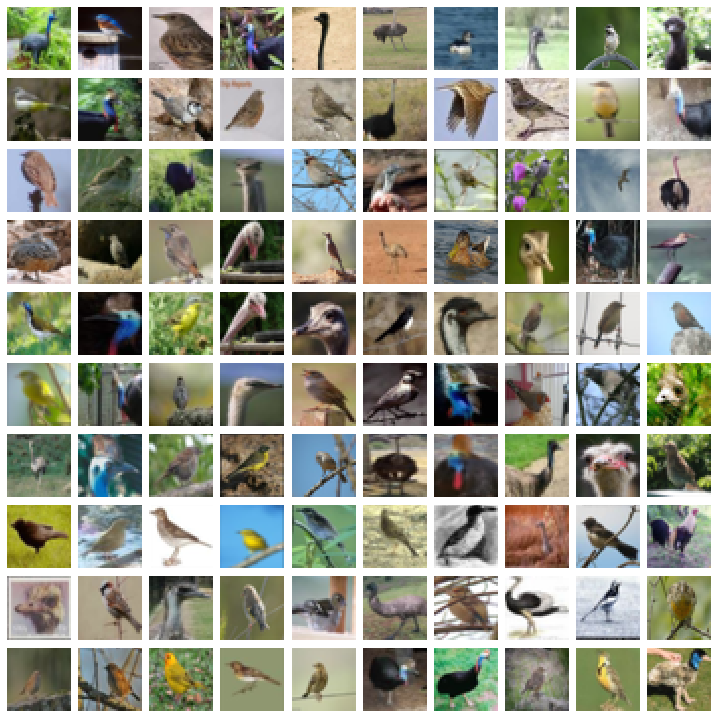

In [3]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
        for j in range(10):
                axes[i][j].matshow(_dataset_to_augment[i*10 +j].reshape(32, 32, 3), cmap='gray')
                axes[i][j].axis('off')

plt.tight_layout(pad=0.8)

## Let's build a custom auto-encoding architecture!

### First thing, you need to import the ``BaseEncoder`` and ``BaseDecoder`` classes from pyraug by running

In [4]:
from pyraug.models.nn import BaseEncoder, BaseDecoder

### Then build your own architectures

In [78]:
import torch.nn as nn

class Encoder_Conv(BaseEncoder):
    def __init__(self, args):
        BaseEncoder.__init__(self)
        self.latent_dim = args.latent_dim
        self.n_channels = 3

        self.layers = nn.Sequential(
            nn.Conv2d(
                self.n_channels, out_channels=32, kernel_size=3, stride=2, padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.fc1 = nn.Sequential(nn.Linear(512, 400), nn.ReLU())

        self.mu = nn.Linear(400, self.latent_dim)
        self.std = nn.Linear(400, self.latent_dim)

    def forward(self, x):
        out = self.layers(
            x.reshape(
                -1, self.n_channels, 32, 32
                )
            )
        out = self.fc1(out.reshape(x.shape[0], -1))
        return self.mu(out), self.std(out)


class Decoder_Conv(BaseDecoder):
    def __init__(self, args):
        BaseDecoder.__init__(self)

        self.latent_dim = args.latent_dim
        self.n_channels = 3

        self.fc1 = nn.Sequential(
            nn.Linear(self.latent_dim, 400), nn.ReLU(), nn.Linear(400, 512), nn.ReLU()
        )

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(
                32,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(
                32,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(
                32,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=0,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(
                32,
                out_channels=self.n_channels,
                kernel_size=2,
                stride=1,
            ),
            nn.BatchNorm2d(self.n_channels),
            nn.Sigmoid(),
        )

    def forward(self, z):
        out = self.fc1(z)
        out = self.layers(out.reshape(z.shape[0], 32, 4, 4))
        return out.reshape(z.shape[0], -1)

### Define a model configuration (in which the latent will be stated). Here, we use the RHVAE model.

In [79]:
from pyraug.models.rhvae import RHVAEConfig

model_config = RHVAEConfig(
    input_dim=3*32*32, # This is needed since will use a predefined metric network that requires the input dim to be                           # built automatically
    latent_dim=10
    )

### Build your encoder and decoder

In [80]:
encoder = Encoder_Conv(model_config)
decoder= Decoder_Conv(model_config)

tensor([[0.5403, 0.5080, 0.6187,  ..., 0.5258, 0.4784, 0.4290],
        [0.5586, 0.5064, 0.6423,  ..., 0.6023, 0.4999, 0.4568],
        [0.5871, 0.6154, 0.4094,  ..., 0.5504, 0.5171, 0.4253],
        ...,
        [0.5538, 0.5256, 0.6224,  ..., 0.5536, 0.5038, 0.4424],
        [0.5257, 0.5895, 0.5032,  ..., 0.4902, 0.5122, 0.4708],
        [0.5588, 0.5203, 0.6588,  ..., 0.5673, 0.4685, 0.4504]],
       grad_fn=<ViewBackward>)

### Last but not least. Build you RHVAE model by passing the ``encoder`` and ``decoder`` arguments

In [81]:
from pyraug.models import RHVAE

model = RHVAE(
    model_config=model_config,
    encoder=encoder,
    decoder=decoder
)

### Now you can see the model that you've just built contains the custom autoencoder and decoder

In [82]:
model

RHVAE(
  (encoder): Encoder_Conv(
    (layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
    (fc1): Sequential(
      (0): Linear(in_features=512, out_features=400, bias=True)
      (1): ReLU()
    )
    (mu): Linear(in_features=400, out_features=10, bias=True)
    (std): Linear(in_features=400, out_features=10, bias=True)
  )
  (decoder): Decoder_Conv(
    (fc1): Sequential(
      (0): Linear(in_features=10, out_features=400, bias=True)
      (1): ReLU()
      

### *note*: If you want to launch a training of such a model, try to ensure that the provided architectures are suited for the data. pyraug performs a model sanity check before launching training and raises an error if the model cannot encode and decode an input data point

## Train the model !

### Likewise tutorial 1, you can now trained you model.

In [83]:
from pyraug.trainers.training_config import TrainingConfig
from pyraug.pipelines import TrainingPipeline

### Build the training pipeline with your ``TrainingConfig`` instance

In [104]:
training_config = TrainingConfig(
    output_dir='my_model_with_custom_archi',
    no_cuda=False,
    learning_rate=1e-3,
    batch_size=200,
    train_early_stopping=100,
    steps_saving=None,
    max_epochs=2000)

In [105]:
pipeline = TrainingPipeline(
    data_loader=None,
    data_processor=None,
    model=model,
    optimizer=None,
    training_config=training_config)

### Launch the ``Pipeline``

In [106]:
# set channel first
dataset_to_augment = np.transpose(_dataset_to_augment, (0, 3, 2, 1))

torch.manual_seed(8)
torch.cuda.manual_seed(8)

pipeline(
    train_data=dataset_to_augment,
    log_output_dir='output_logs'
)

Data normalized using individual_min_max_scaling.
 -> If this is not the desired behavior pass an instance of DataProcess with 'data_normalization_type' attribute set to desired normalization or None

Model passed sanity check !

Created my_model_with_custom_archi/training_2021-06-30_15-23-18. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !
----------------------------------
Training ended!
Saved final model in my_model_with_custom_archi/training_2021-06-30_15-23-18/final_model


### *note 1*: You will see now that a ``encoder.pkl`` and ``decoder.pkl`` appear in the folder ``my_model_with_custom_archi/trainin_YYYY_MM_DD_hh_mm_ss/final_model`` to allow model rebuilding with your own architecture ``Encoder_Conv`` and ``Decoder_Conv``.

### *note 2*: Model rebuilding is based on the [dill](https://pypi.org/project/dill/) librairy allowing to reload the class whithout importing them. Hence, you should still be able to reload the model even if the classes ``Encoder_Conv`` or ``Decoder_Conv`` were not imported.  

### You can now reload the model easily using the classmethod ``RHVAE.load_from_folder``

In [107]:
last_training = sorted(os.listdir('my_model_with_custom_archi'))[-1]
print(last_training)

training_2021-06-30_15-23-18


In [108]:
model_rec = RHVAE.load_from_folder(os.path.join('my_model_with_custom_archi', last_training, 'final_model'))
model_rec

RHVAE(
  (encoder): Encoder_Conv(
    (layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
    (fc1): Sequential(
      (0): Linear(in_features=512, out_features=400, bias=True)
      (1): ReLU()
    )
    (mu): Linear(in_features=400, out_features=10, bias=True)
    (std): Linear(in_features=400, out_features=10, bias=True)
  )
  (decoder): Decoder_Conv(
    (fc1): Sequential(
      (0): Linear(in_features=10, out_features=400, bias=True)
      (1): ReLU()
      

## Likewise tutorial 1, the model can then be used to generate new samples !

In [134]:
from pyraug.models.rhvae import RHVAESamplerConfig
from pyraug.models.rhvae.rhvae_sampler import RHVAESampler

sampler_config = RHVAESamplerConfig(
        output_dir='my_generated_data_with_custom_archi',
        mcmc_steps_nbr=50,
        eps_lf=0.001,
        batch_size=100,
        no_cuda=False
        )

sampler = RHVAESampler(
    model=model_rec,
    sampler_config=sampler_config
)

In [135]:
from pyraug.pipelines import GenerationPipeline

generation_pipe = GenerationPipeline(
    model=model,
    sampler=sampler
)

In [140]:
torch.manual_seed(8)
torch.cuda.manual_seed(8)

generation_pipe(100)

Created my_generated_data_with_custom_archi/generation_2021-06-30_15-41-36.Generated data and sampler config will be saved here.

Generation successfully launched !



In [141]:
last_generation = sorted(os.listdir('my_generated_data_with_custom_archi'))[-1]

In [142]:
generated_data = torch.load(os.path.join('my_generated_data_with_custom_archi', last_generation, 'generated_data_100_0.pt'))

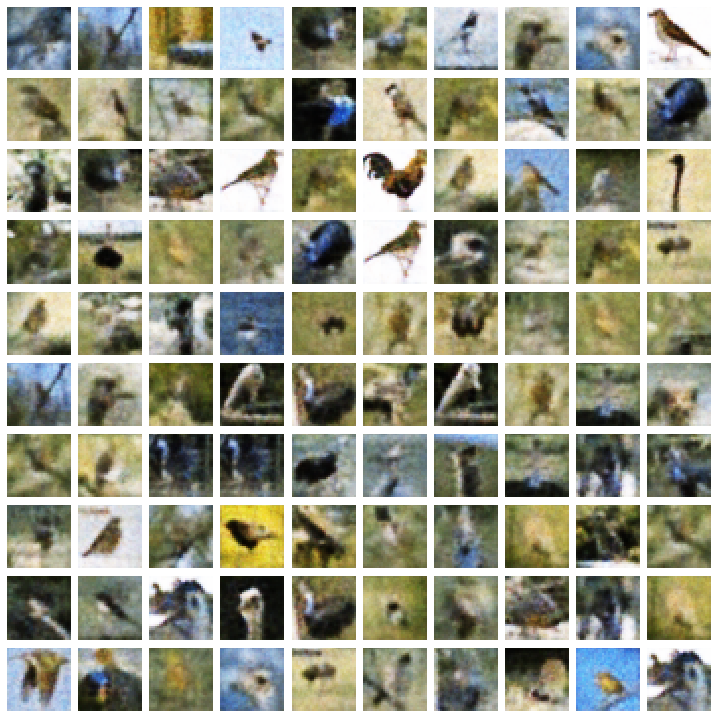

In [143]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
im_n = 0
for i in range(10):
    for j in range(10):
                axes[i][j].matshow(np.transpose(generated_data[i*10 +j].cpu().reshape(3, 32, 32), (2, 1,0)) , cmap='gray')
                axes[i][j].axis('off')

plt.tight_layout(pad=0.8)

In [144]:
for i in range(len(generated_data)):
    for j in range(i+1, len(generated_data)):
        assert not torch.equal(generated_data[j].cpu(), torch.tensor(generated_data[i]).cpu().type(torch.float)), (i, j)

<ipython-input-144-e8c52415bc02>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  assert not torch.equal(generated_data[j].cpu(), torch.tensor(generated_data[i]).cpu().type(torch.float)), (i, j)
